In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
from arch import arch_model
import matplotlib.pyplot as plt

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

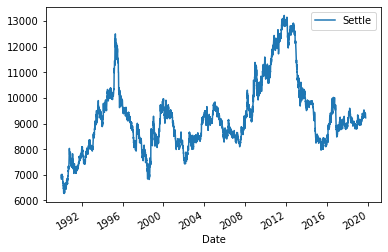

In [4]:
# Plot just the "Settle" column from the dataframe:
yen_futures[["Settle"]].plot()

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])

In [6]:
print(ts_noise)

Date
1990-01-02   -61.503967
1990-01-03   -21.799756
1990-01-04    98.942896
1990-01-05    40.776052
1990-01-08    49.689938
                ...    
2019-10-09    24.939247
2019-10-10    -5.868559
2019-10-11   -54.454594
2019-10-14   -36.423060
2019-10-15   -75.844123
Name: Settle_cycle, Length: 7515, dtype: float64


In [7]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
HPF_yen_futures = yen_futures[["Settle"]]
HPF_yen_futures["noise"]= ts_noise
HPF_yen_futures["trend"] = ts_trend
HPF_yen_futures

<ipython-input-7-6468da5df30b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HPF_yen_futures["noise"]= ts_noise
<ipython-input-7-6468da5df30b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HPF_yen_futures["trend"] = ts_trend


,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062
...,...,...,...
2019-10-09,9338.0,24.939247,9313.060753
2019-10-10,9303.5,-5.868559,9309.368559
2019-10-11,9251.0,-54.454594,9305.454594


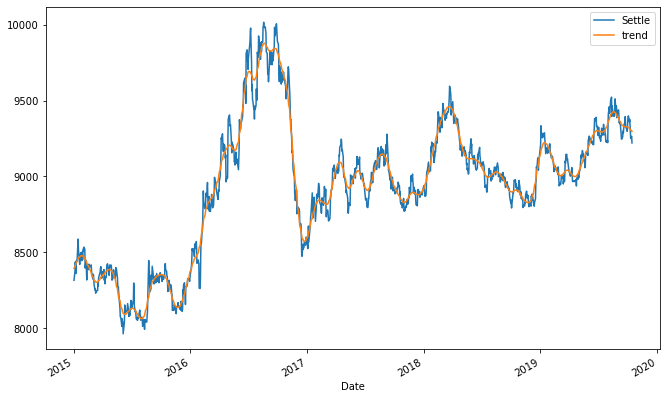

In [8]:
# Plot the Settle Price vs. the Trend for 2015 to the present
HPF_yen_futures[["Settle","trend"]].loc["2015-01-01":, :].plot(figsize= (11,7))

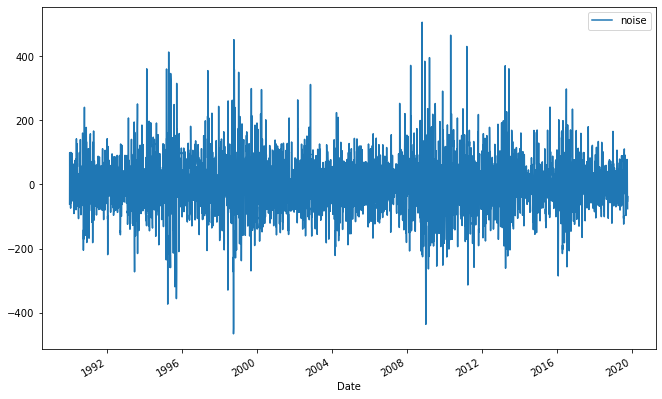

In [9]:
# Plot the Settle Noise
HPF_yen_futures[["noise"]].plot(figsize= (11,7))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [10]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [11]:
returns['Diff'] = returns.Settle.diff().dropna().copy()
returns = returns.dropna().copy()
returns

,Settle,Diff
Date,,
1990-01-04,1.756933,1.172736
1990-01-05,-0.827626,-2.584559
1990-01-08,0.129496,0.957122
1990-01-09,-0.632275,-0.761771
1990-01-10,-0.404917,0.227358
...,...,...
2019-10-09,-0.410601,-0.581532
2019-10-10,-0.369458,0.041143
2019-10-11,-0.564304,-0.194846


/Users/macbookmaladocs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Diff   No. Observations:                 7513
Model:                     ARMA(2, 1)   Log Likelihood               -7897.827
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sat, 24 Apr 2021   AIC                          15805.654
Time:                        19:28:41   BIC                          15840.276
Sample:                             0   HQIC                         15817.541
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.238e-06   3.85e-06     -0.842      0.400   -1.08e-05     4.3e-06
ar.L1.Diff    -0.0136      0.012     -1.183      0.237      -0.036       0.009
ar.L2.Diff     0.0056      0.012      0.482      0.630      -0.017       0.028
ma.L1.Diff    -0.9999      0.000  -2262.977      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -12.2319           +0.0000j           12.2319            0.5000
AR.2           14.6822           +0.0000j           14.6822            0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

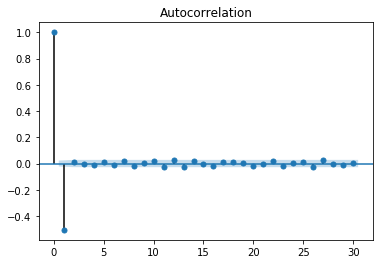

In [12]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(returns['Diff'], lags = 30)
import matplotlib.pyplot as plt

# Estimate and ARMA model using statsmodels (use order=(2, 1)) p = 2, q = 1
model = sm.tsa.ARMA(returns['Diff'], order=(2, 1))


# Fit the model and assign it to a variable called results
results = model.fit()
results.summary()

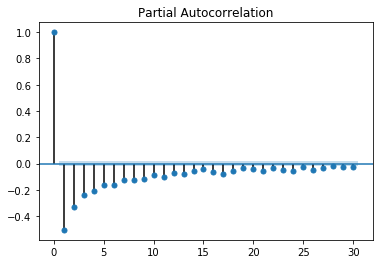

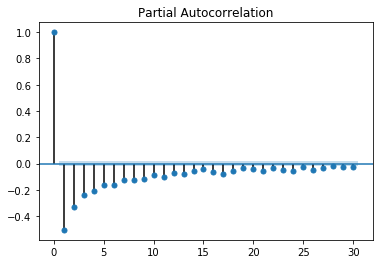

In [13]:
# Output model summary results:
plot_pacf(returns['Diff'], lags = 30)

In [14]:
#Find last day
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

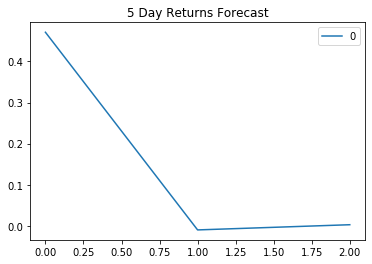

In [15]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=3)[0]).plot(title="5 Day Returns Forecast")
#forecast_horizon = 5
#forecasts = returns.predict(start=last_day, horizon=forecast_horizon)

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [16]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(yen_futures[["Settle"]], order=(2, 1, 2))

# Fit the model
rawYen = model.fit()


/Users/macbookmaladocs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/macbookmaladocs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [17]:
# Output model summary results:
rawYen.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -41945.747
Method:                       css-mle   S.D. of innovations             64.290
Date:                Sat, 24 Apr 2021   AIC                          83903.494
Time:                        19:28:44   BIC                          83945.041
Sample:                             1   HQIC                         83917.759
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3158      0.705      0.448      0.654      -1.066       1.698
ar.L1.D.Settle    -0.1331      0.620     -0.214      0.830      -1.349       1.083
ar.L2.D.Settle     0.5461      0.434      1.257      0.209      -0.305       1.397
ma.L1.D.Settle     0.1177      0.619      0.190      0.849      -1.096       1.331
ma.L2.D.Settle    -0.5595      0.441     -1.269      0.205      -1.424       0.305
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2369           +0.0000j            1.2369            0.5000
AR.2            1.4806           +0.0000j            1.4806            0.0000
MA.1           -1.2358           +0.0000j            1.2358            0.5000
MA.2            1.4462           +0.0000j            1.4462            0.0000
-----------------------------------------------------------------------------
"""

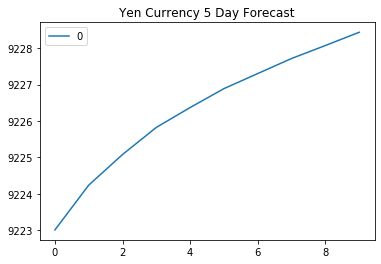

In [18]:
# Plot the 5 Day Price Forecast
pd.DataFrame(rawYen.forecast(steps=10)[0]).plot(title="Yen Currency 5 Day Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [19]:
# Estimate a GARCH model:
model = arch_model(yen_futures[["Settle"]], mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 248789.98558438313
Iteration:      2,   Func. Count:     14,   Neg. LLF: 79212.87409023142
Iteration:      3,   Func. Count:     19,   Neg. LLF: 79212.87046294869
Iteration:      4,   Func. Count:     24,   Neg. LLF: 79212.8556658887
Iteration:      5,   Func. Count:     29,   Neg. LLF: 79212.83595080001
Iteration:      6,   Func. Count:     34,   Neg. LLF: 79212.83594649751
Iteration:      7,   Func. Count:     39,   Neg. LLF: 79212.83594804774
Iteration:      8,   Func. Count:     44,   Neg. LLF: 79212.83594548811
Optimization terminated successfully    (Exit mode 0)
            Current function value: 79212.83594548574
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


/Users/macbookmaladocs/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.872e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [20]:
# Summarize the model results
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -79212.8
Distribution:                  Normal   AIC:                           158434.
Method:            Maximum Likelihood   BIC:                           158461.
                                        No. Observations:                 7515
Date:                Sat, Apr 24 2021   Df Residuals:                     7515
Time:                        19:28:44   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.7475e+06  1.135e+05     15.399  1.668e-53  [1.525e+06,1.970e+06]
alpha[1]       0.9762  1.706e-02     57.222      0.000      [  0.943,  1.010]
alpha[2]   2.3745e-03  5.384e-02  4.410e-02      0.965      [ -0.103,  0.108]
beta[1]        0.0000  5.093e-02      0.000      1.000 [-9.982e-02,9.982e-02]
=============================================================================

Covariance estimator: robust
"""

In [21]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [29]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = model_fit.forecast(start='2019-10-15', horizon=forecast_horizon)

/Users/macbookmaladocs/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [30]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,146322.255059,146257.600787,146194.306175,146132.339642,146071.673866


In [31]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,146322.255059
h.2,146257.600787
h.3,146194.306175
h.4,146132.339642
h.5,146071.673866


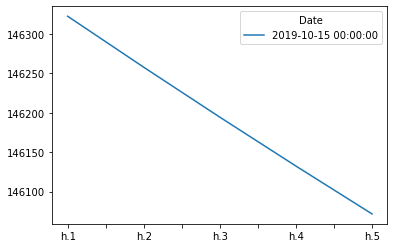

In [32]:
# Plot the final forecast
final.plot()

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?